In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, os, subprocess, re, joblib
from docx import Document
from pdf2docx import Converter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')

In [2]:
# converting doc files to docx files using libre office 
# because python-docx works for only .docx not .doc which is older version
def convert_doc_to_docx(folder_path):
    doc_found = False 
    for root, _, files in os.walk(folder_path): # returns current folder, subfolders and list of files
        for file in files: # iterate over each file
            if (file.lower().endswith(".doc") and not file.lower().endswith(".docx")):
                doc_found = True
                doc_path = os.path.join(root, file) # concatenate the path
                # Convert .doc to .docx in the same folder
                try:
                    subprocess.run([
                        'soffice',
                        '--headless',
                        '--convert-to', 'docx',
                        '--outdir', root,
                        doc_path
                    ], check=True)
                    print(f"Converted: {file} to docx")

                    # Delete the original .doc file after successful conversion
                    os.remove(doc_path)
                    print(f"{'-'*30}Removed original: {file}")

                except subprocess.CalledProcessError as e:
                    print(f"Conversion failed for {file} | Error: {e}")
    if not doc_found:
        print("No .doc file exists")

In [3]:
folder = r'E:\P567 Dataset\P-561 Dataset\Resumes_Docx'
convert_doc_to_docx(folder)

No .doc file exists


In [4]:
# converting pdf file to docx file
def convert_pdf_to_docx(pdf_path):
    try:
        # Define output path
        output_path = os.path.splitext(pdf_path)[0] + ".docx"

        # Convert PDF to DOCX
        cv = Converter(pdf_path)
        cv.convert(output_path, start=0, end=None) # Convert the file starting from page 0 to the last page
        cv.close()

        # Check if output was created before deleting original
        if os.path.exists(output_path):
            os.remove(pdf_path)
            print(f"Converted: {pdf_path} -----> {output_path}")
            print(f"Removed original: {pdf_path}")
        else:
            print(f"Conversion did not create output: {output_path} — original kept")

    except Exception as e:
        print(f"Conversion failed for {pdf_path}: {e}")

In [5]:
pdf_path = r'E:\P567 Dataset\P-561 Dataset\Resumes_Docx\React Developer\Reactjs Developer_Prabakaran_Musquare Technologies.pdf'
convert_pdf_to_docx(pdf_path)

Conversion failed for E:\P567 Dataset\P-561 Dataset\Resumes_Docx\React Developer\Reactjs Developer_Prabakaran_Musquare Technologies.pdf: no such file: 'E:\P567 Dataset\P-561 Dataset\Resumes_Docx\React Developer\Reactjs Developer_Prabakaran_Musquare Technologies.pdf'


In [6]:
def extract_full_text(file_path):
    doc = Document(file_path)
    full_text = []

    # Extract paragraph text
    for para in doc.paragraphs:
        if para.text.strip(): 
            full_text.append(para.text.strip()) # remove spaces and append to list

    # Extract table text
    for table in doc.tables:
        for row in table.rows:
            row_data = [cell.text.strip() for cell in row.cells if cell.text.strip()]
            if row_data:
                 # join '|' to differenciate between table text and normal text (optional)
                full_text.append(' | '.join(row_data))

    return '\n'.join(full_text)

def process_resumes_from_folders(parent_folder):
    all_data = []
    total_files = 0
    # For each subfolder (label), read .docx files and extract text with label
    for label in os.listdir(parent_folder): 
        label_path = os.path.join(parent_folder, label)
        if os.path.isdir(label_path):
            for file in os.listdir(label_path):
                if file.endswith(".docx"):
                    total_files += 1
                    file_path = os.path.join(label_path, file)
                    try:
                        resume_text = extract_full_text(file_path)
                        all_data.append({'text': resume_text, 'label': label})
                    except Exception as e:
                        print(f"Error processing {file_path}: {e}")
    print(f"Total .docx files found: {total_files}")
    print(f"Successfully processed: {len(all_data)}")
    return pd.DataFrame(all_data)

In [7]:
parent_folder =  r'E:\P567 Dataset\P-561 Dataset\Resumes_Docx'  # Change this to your actual folder path
df = process_resumes_from_folders(parent_folder)

Total .docx files found: 79
Successfully processed: 79


In [8]:
df

,text,label
0,Anubhav Kumar Singh\nTo work in a globally com...,Peoplesoft Resume
1,Profile Summary:\n7+ years of experience in im...,Peoplesoft Resume
2,PeopleSoft Database Administrator\nGangareddy\...,Peoplesoft Resume
3,Murali\nExperience Summary\nI have 6 years of ...,Peoplesoft Resume
4,"Priyanka Ramadoss\n61/46, MountPleasant,\nCoon...",Peoplesoft Resume
...,...,...
74,Workday Integration Consultant\nName :...,workday
75,Seeking suitable positions in Workday HCM as ...,workday
76,WORKDAY | HCM | FCM\nName \t\t: Kumar S.S\nRol...,workday
77,Venkateswarlu.B\t\t\t\t\t\t\t\tWorkday Consult...,workday


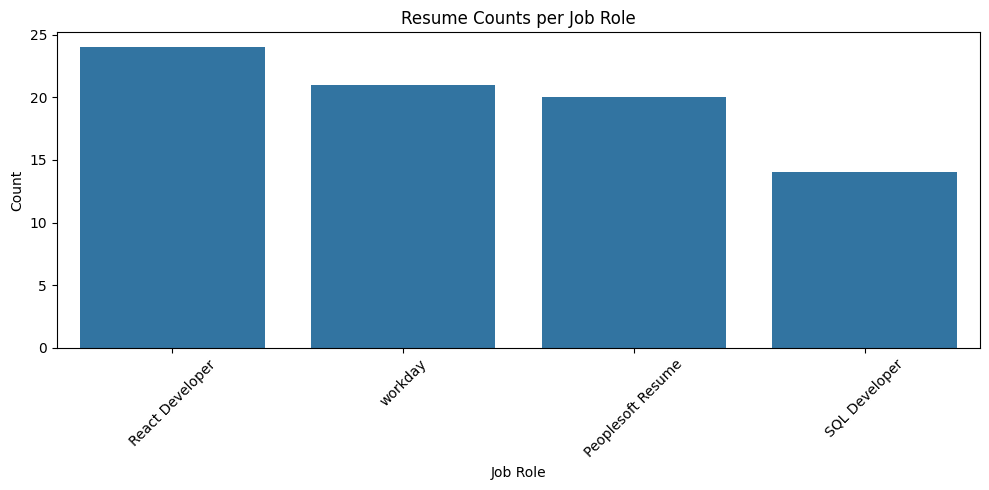

In [9]:
plt.figure(figsize=(10,5))
sns.countplot(x='label', data=df, order=df['label'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Resume Counts per Job Role')
plt.xlabel('Job Role')
plt.ylabel('Count')
plt.tight_layout()

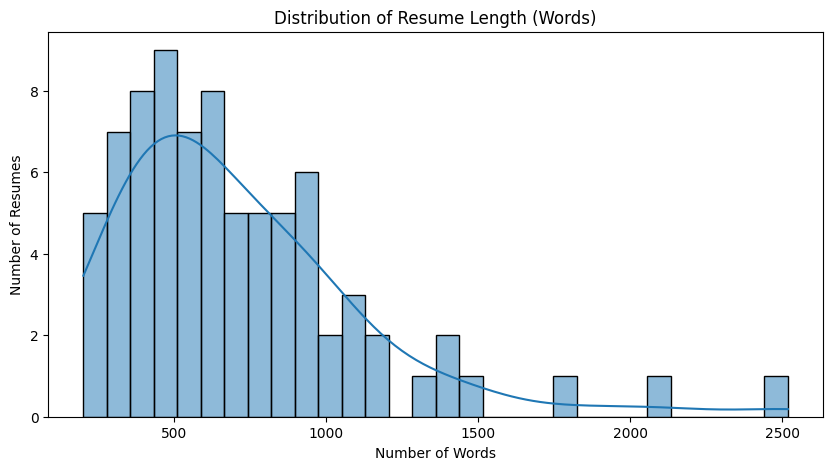

In [10]:
text_length = df['text'].apply(lambda x: len(x.split())) # gives the word count of the resume

plt.figure(figsize=(10,5))
sns.histplot(text_length, bins=30, kde=True)
plt.title('Distribution of Resume Length (Words)')
plt.xlabel('Number of Words')
plt.ylabel('Number of Resumes');

In [11]:
df

,text,label
0,Anubhav Kumar Singh\nTo work in a globally com...,Peoplesoft Resume
1,Profile Summary:\n7+ years of experience in im...,Peoplesoft Resume
2,PeopleSoft Database Administrator\nGangareddy\...,Peoplesoft Resume
3,Murali\nExperience Summary\nI have 6 years of ...,Peoplesoft Resume
4,"Priyanka Ramadoss\n61/46, MountPleasant,\nCoon...",Peoplesoft Resume
...,...,...
74,Workday Integration Consultant\nName :...,workday
75,Seeking suitable positions in Workday HCM as ...,workday
76,WORKDAY | HCM | FCM\nName \t\t: Kumar S.S\nRol...,workday
77,Venkateswarlu.B\t\t\t\t\t\t\t\tWorkday Consult...,workday


In [12]:
''' 
    Full Form:
    "PS": "PeopleSoft"
    "WF": "WorkFlow"
    "WD": "Workday"
    "PL/SQL": "Procedural Language SQL"
    "CI/CD": "Continuous Integration and Continuous Delivery"
    "ETL" : "Extract-Load-Transform"
    "SOAP" : "Simple Object Access Protocol"
    "JSON" : "JavaScript Object Notation"
'''
lemma = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Known skills as present in resume skills, converted to lowercase to match lowercased text
known_skills = {
    "sql", "ps", "wf", "react", "js", "wd", "api", "db", "etl", "ai",
    "pl/sql", "html", "css", "aws", "json", "rest", "soap", "ci/cd",
}

def clean_text(text):
    # Remove non-letters and lowercase
    text = re.sub('[^a-zA-Z]', ' ', text) # keep only capital and small alphabets
    text = text.lower() 
    
    # Tokenize
    words = text.split()
    
    # Lemmatize words except known skills, also remove stopwords
    cleaned_words = [
        word if word in known_skills else lemma.lemmatize(word)
        for word in words
        if word not in stop_words
    ]
    return ' '.join(cleaned_words)

In [13]:
# apply function to text column
df['clean_text'] = df['text'].apply(clean_text)

In [14]:
df['text'][0][0:100]

'Anubhav Kumar Singh\nTo work in a globally competitive environment on\nchallenging assignments that sh'

In [15]:
df['clean_text'][0][0:100]

'anubhav kumar singh work globally competitive environment challenging assignment shall yield twin be'

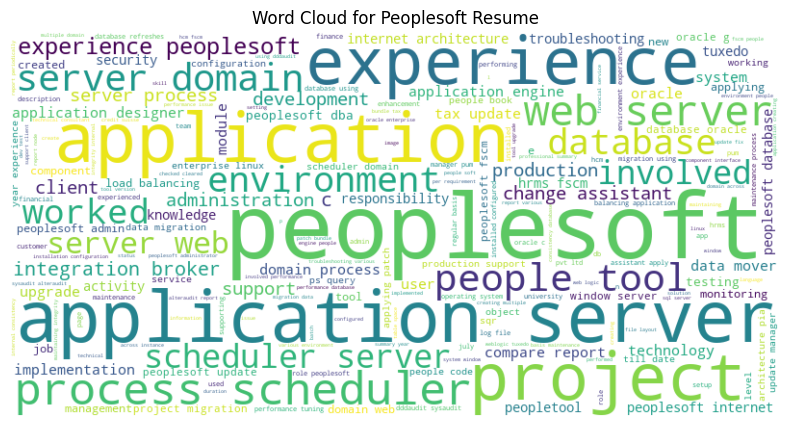

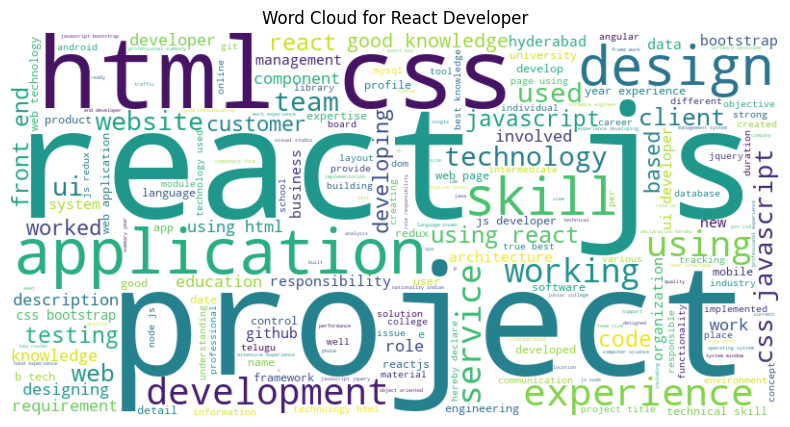

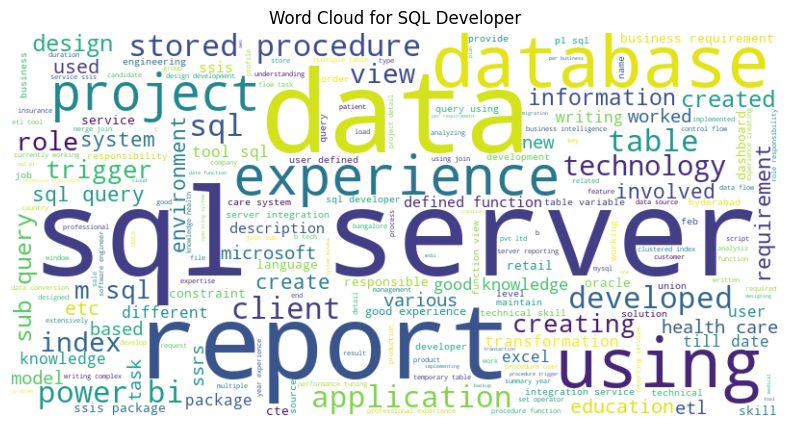

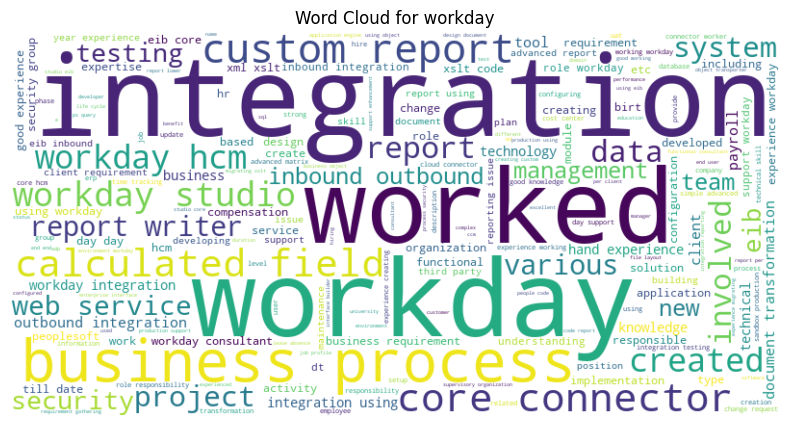

In [16]:
labels = df['label'].unique() # get all unique labels
for label in labels: # loop through each unique class
    text = ' '.join(df[df['label'] == label]['clean_text'].values) # combine all text for that label
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {label}')

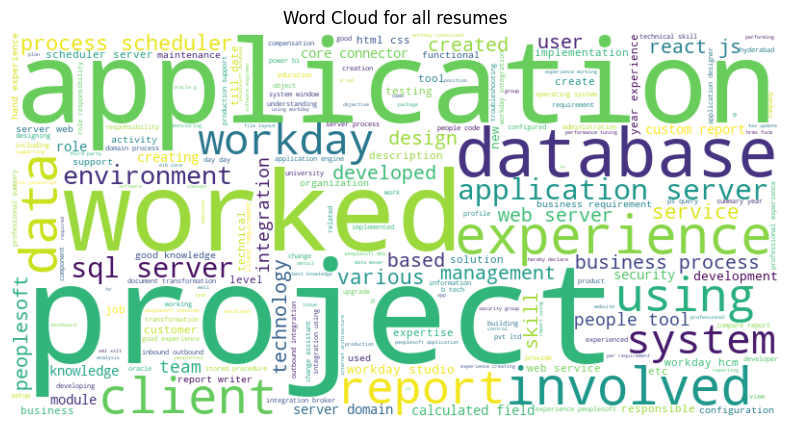

In [17]:
text1 = ' '.join(df['clean_text']) 
wc1 = WordCloud(width=800, height=400, background_color='white').generate(text1)
plt.figure(figsize=(10,5))
plt.imshow(wc1, interpolation='bilinear')
plt.axis('off')
plt.title(f'Word Cloud for all resumes');

In [18]:
df

,text,label,clean_text
0,Anubhav Kumar Singh\nTo work in a globally com...,Peoplesoft Resume,anubhav kumar singh work globally competitive ...
1,Profile Summary:\n7+ years of experience in im...,Peoplesoft Resume,profile summary year experience implementing u...
2,PeopleSoft Database Administrator\nGangareddy\...,Peoplesoft Resume,peoplesoft database administrator gangareddy p...
3,Murali\nExperience Summary\nI have 6 years of ...,Peoplesoft Resume,murali experience summary year experience work...
4,"Priyanka Ramadoss\n61/46, MountPleasant,\nCoon...",Peoplesoft Resume,priyanka ramadoss mountpleasant coonoor nilgir...
...,...,...,...
74,Workday Integration Consultant\nName :...,workday,workday integration consultant name sri krishn...
75,Seeking suitable positions in Workday HCM as ...,workday,seeking suitable position workday hcm techno f...
76,WORKDAY | HCM | FCM\nName \t\t: Kumar S.S\nRol...,workday,workday hcm fcm name kumar role workday consul...
77,Venkateswarlu.B\t\t\t\t\t\t\t\tWorkday Consult...,workday,venkateswarlu b workday consultant year experi...


### FEATURE ENGINEERING

In [20]:
le = LabelEncoder()
y = le.fit_transform(df['label'])

### MODEL BUILDING

In [ ]:
x_train_text, x_test_text, y_train, y_test = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, random_state=42
)

In [22]:
tf_idf = TfidfVectorizer(max_features=None)

x_train = tf_idf.fit_transform(x_train_text)   # fit only on train
x_test  = tf_idf.transform(x_test_text)        # transform test with same vocab

In [23]:
logr = LogisticRegression(random_state = 42, multi_class = 'multinomial')
logr.fit(x_train, y_train)
y_pred_logr = logr.predict(x_test)
print(f'Logistic Regression Training Accuracy: {logr.score(x_train, y_train)}')
print(f'Logistic Regression Testing Accuracy: {logr.score(x_test, y_test)}')
print(classification_report(y_test, y_pred_logr))

Logistic Regression Training Accuracy: 1.0
Logistic Regression Testing Accuracy: 0.9375
                   precision    recall  f1-score   support

Peoplesoft Resume       1.00      0.80      0.89         5
  React Developer       0.86      1.00      0.92         6
    SQL Developer       1.00      1.00      1.00         2
          workday       1.00      1.00      1.00         3

         accuracy                           0.94        16
        macro avg       0.96      0.95      0.95        16
     weighted avg       0.95      0.94      0.94        16



In [24]:
cnb = ComplementNB()
cnb.fit(x_train, y_train)
y_pred_cnb = cnb.predict(x_test)
print(f'Complement NB Training Accuracy: {cnb.score(x_train, y_train)}')
print(f'Complement NB Testing Accuracy: {cnb.score(x_test, y_test)}')
print(classification_report(y_test, y_pred_cnb))

Complement NB Training Accuracy: 1.0
Complement NB Testing Accuracy: 1.0
                   precision    recall  f1-score   support

Peoplesoft Resume       1.00      1.00      1.00         5
  React Developer       1.00      1.00      1.00         6
    SQL Developer       1.00      1.00      1.00         2
          workday       1.00      1.00      1.00         3

         accuracy                           1.00        16
        macro avg       1.00      1.00      1.00        16
     weighted avg       1.00      1.00      1.00        16



In [25]:
mnb = MultinomialNB()
mnb.fit(x_train, y_train)
y_pred_mnb = mnb.predict(x_test)
print(f'Multinomial NB Training Accuracy: {mnb.score(x_train, y_train)}')
print(f'Multinomial NB Testing Accuracy: {mnb.score(x_test, y_test)}')
print(classification_report(y_test, y_pred_mnb))

Multinomial NB Training Accuracy: 1.0
Multinomial NB Testing Accuracy: 0.9375
                   precision    recall  f1-score   support

Peoplesoft Resume       1.00      0.80      0.89         5
  React Developer       1.00      1.00      1.00         6
    SQL Developer       1.00      1.00      1.00         2
          workday       0.75      1.00      0.86         3

         accuracy                           0.94        16
        macro avg       0.94      0.95      0.94        16
     weighted avg       0.95      0.94      0.94        16



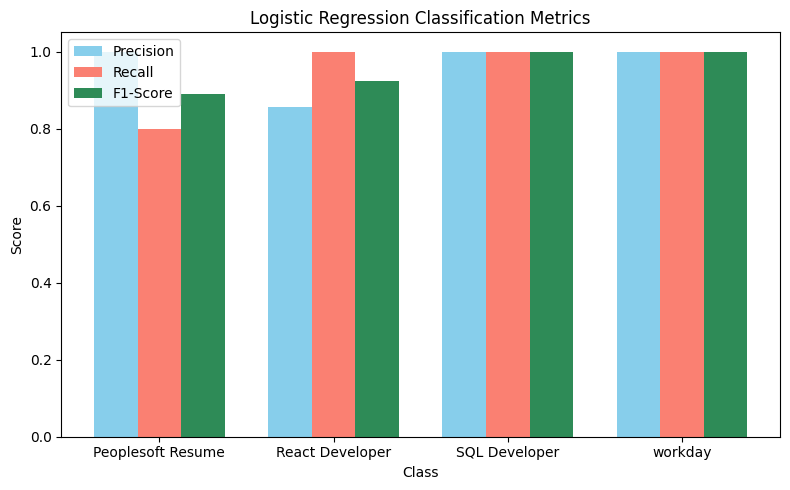

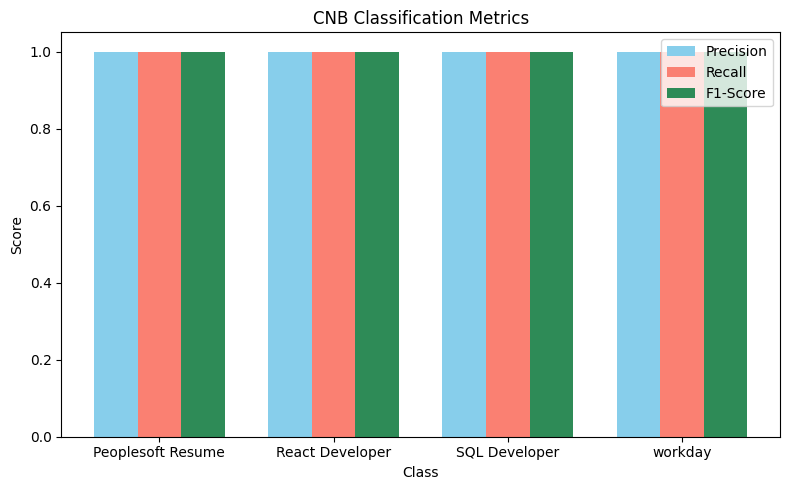

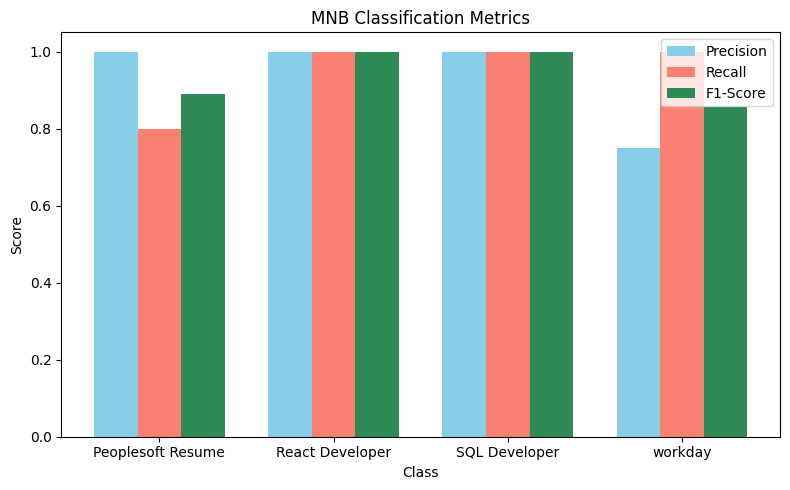

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Unique class labels
classes = np.unique(y_test)
x = np.arange(len(classes))
bar_width = 0.25

# List of models and predictions
models = {
    'Logistic Regression': y_pred_logr,
    'CNB': y_pred_cnb,
    'MNB': y_pred_mnb
}

# Colors for metrics
metric_colors = {'Precision':'skyblue', 'Recall':'salmon', 'F1':'seagreen'}

for model_name, y_pred in models.items():
    precision = precision_score(y_test, y_pred, average=None, labels=classes)
    recall = recall_score(y_test, y_pred, average=None, labels=classes)
    f1 = f1_score(y_test, y_pred, average=None, labels=classes)
    
    plt.figure(figsize=(8,5))
    plt.bar(x - bar_width, precision, width=bar_width, color=metric_colors['Precision'], label='Precision')
    plt.bar(x, recall, width=bar_width, color=metric_colors['Recall'], label='Recall')
    plt.bar(x + bar_width, f1, width=bar_width, color=metric_colors['F1'], label='F1-Score')
    
    plt.xticks(x, [str(c) for c in classes])
    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.ylim(0, 1.05)
    plt.title(f'{model_name} Classification Metrics')
    plt.legend()
    plt.tight_layout()
    plt.show()


### PIPELINE

In [27]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features = None, preprocessor = clean_text)),
    ('CNB', ComplementNB())
])
# creating new x, y for pipeline usage
x_pipe = df['text']
label_en = LabelEncoder()
y_pipe = label_en.fit_transform(df['label'])
x_train_pipe, x_test_pipe, y_train_pipe, y_test_pipe = train_test_split(x_pipe, y_pipe, test_size = 0.2, 
                                                                    random_state = 42, stratify = y_pipe)

# Fit pipeline
pipeline.fit(x_train_pipe, y_train_pipe)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(preprocessor=<function clean_text at 0x000001A2BFB73670>)),
                ('CNB', ComplementNB())])

In [28]:
# just to verify that pipeline works perfectly 
print(f'Pipeline Training Accuracy: {pipeline.score(x_train_pipe, y_train_pipe)}')
print(f'Pipeline Testing Accuracy: {pipeline.score(x_test_pipe, y_test_pipe)}')

Pipeline Training Accuracy: 1.0
Pipeline Testing Accuracy: 1.0


In [29]:
# # Save full pipeline
# joblib.dump(pipeline, "E://Models//Resume_Pipeline.pkl")

['E://Models//Resume_Pipeline.pkl']

In [30]:
label_en.classes_

array(['Peoplesoft Resume', 'React Developer', 'SQL Developer', 'workday'],
      dtype=object)